* Train an RNN on technical papers from https://arvix.org/
* Beautiful Soup - parse HTML and XML documents in the form of a document tree.

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [0]:
import os
import requests
import random

In [0]:
from bs4 import BeautifulSoup

In [0]:
import numpy as np
import tensorflow as tf

In [0]:
print(np.__version__)
print(tf.__version__)

1.17.3
1.15.0


### Query the data and extract information

Download papers with mentioned categories and keywords

In [0]:
BASE_PATH = 'http://export.arxiv.org/api/query'
CATEGORIES = [
    'Machine Learning',
    'Natural Language Processing',
    'Neural Networks',
    'Artifical Intelligence'
]
KEYWORDS = [
    'neural',
    'intelligence'
    'network',
    'deep'    
]

### Helper function to build the url to extract data
- number of pages
- offset of the page

In [0]:
def build_url(amount, offset):
    categories = ' OR '.join('cat:' + x for x in CATEGORIES)
    keywords = ' OR '.join('all:' + x for x in KEYWORDS)

    url = BASE_PATH
    url += '?search_query=(({}) AND ({}))'.format(categories, keywords)
    url += '&max_results={}&offset={}'.format(amount, offset)
    
    return url

In [0]:
def get_count():
    url = build_url(0, 0)
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'lxml')
    
    count = int(soup.find('opensearch:totalresults').string)
    print(count, 'papers found')
    
    return count

In [0]:
num_papers = get_count()

65543 papers found


In [0]:
PAGE_SIZE = 100

def fetch_page(amount, offset):
    url = build_url(amount, offset)
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'lxml')
    
    for entry in soup.findAll('entry'):
        text = entry.find('summary').text
        text = text.strip().replace('\n', ' ')
        yield text

def fetch_all():
    for offset in range(0, num_papers, PAGE_SIZE):
        print('Fetch papers {}/{}'.format(offset + PAGE_SIZE, num_papers))
        
        for page in fetch_page(PAGE_SIZE, offset):
            yield page

In [0]:
DOWNLOADED_FILENAME = 'arxiv_abstracts.txt'

def download_data():
    if not os.path.isfile(DOWNLOADED_FILENAME):
        with open(DOWNLOADED_FILENAME, 'w') as file_:
            for abstract in fetch_all():
                file_.write(abstract + '\n')
    with open(DOWNLOADED_FILENAME) as file_:
        data = file_.readlines()
        
    return data    

In [0]:
data = download_data()

Fetch papers 100/65543
Fetch papers 200/65543
Fetch papers 300/65543
Fetch papers 400/65543
Fetch papers 500/65543
Fetch papers 600/65543
Fetch papers 700/65543
Fetch papers 800/65543
Fetch papers 900/65543
Fetch papers 1000/65543
Fetch papers 1100/65543
Fetch papers 1200/65543
Fetch papers 1300/65543
Fetch papers 1400/65543
Fetch papers 1500/65543
Fetch papers 1600/65543
Fetch papers 1700/65543
Fetch papers 1800/65543
Fetch papers 1900/65543
Fetch papers 2000/65543
Fetch papers 2100/65543
Fetch papers 2200/65543
Fetch papers 2300/65543
Fetch papers 2400/65543
Fetch papers 2500/65543
Fetch papers 2600/65543
Fetch papers 2700/65543
Fetch papers 2800/65543
Fetch papers 2900/65543
Fetch papers 3000/65543
Fetch papers 3100/65543
Fetch papers 3200/65543
Fetch papers 3300/65543
Fetch papers 3400/65543
Fetch papers 3500/65543
Fetch papers 3600/65543
Fetch papers 3700/65543
Fetch papers 3800/65543
Fetch papers 3900/65543
Fetch papers 4000/65543
Fetch papers 4100/65543
Fetch papers 4200/65543
F

In [0]:
len(data)

62433

### Number of time steps used when we train data

In [0]:
MAX_SEQUENCE_LENGTH = 100
BATCH_SIZE = 250

In [0]:
VOCABULARY = \
        " $%'()+,-./0123456789:;=?ABCDEFGHIJKLMNOPQRSTUVWXYZ" \
        "\\^_abcdefghijklmnopqrstuvwxyz{|}"

In [0]:
lookup = {x: i for i, x in enumerate(VOCABULARY)}

In [0]:
sample_lookup = random.sample(lookup.items(), 10)
sample_lookup

[('n', 67),
 ('v', 75),
 ('1', 12),
 ('g', 60),
 ('j', 63),
 ('s', 72),
 ('p', 69),
 ('e', 58),
 ('(', 4),
 ('E', 29)]

### One-hot representation of each character
* Every window of characters is of MAX_SEQUENCE_LENGTH (50)
* Each character is represented in one-hot notation
* Every feature vector has length equal to number of characters in the 

---

vocabulary

---



---



---



---



In [0]:
def one_hot(batch, sequence_length = MAX_SEQUENCE_LENGTH):
    one_hot_batch = np.zeros((len(batch), sequence_length, len(VOCABULARY)))

    # Iterate through every line of text in a batch
    for index, line in enumerate(batch):
        line = [x for x in line if x in lookup]
#         assert 2 <= len(line) <= MAX_SEQUENCE_LENGTH
        
        # Iterate through every character in a line
        for offset, character in enumerate(line):
            # Code is the index of the character in the vocabulary
            code = lookup[character]
 
            one_hot_batch[index, offset, code] = 1
    
    return one_hot_batch

### Sliding window over every line
* Generate batches of characters for training data
* Start the sliding window at index 0 for every line
* Slide the window over till the last character in the line is included
* Have a stride of MAX_SEQUENCE_LENGTH // 2 for every window move

In [0]:
def next_batch():
    windows = []
    for line in data:
        for i in range(0, len(line) - MAX_SEQUENCE_LENGTH + 1, MAX_SEQUENCE_LENGTH // 2):
            windows.append(line[i: i + MAX_SEQUENCE_LENGTH])

    while True:
        random.shuffle(windows)
        for i in range(0, len(windows), BATCH_SIZE):
            batch = windows[i: i + BATCH_SIZE]
            yield one_hot(batch)

In [0]:
test_batch = None
for batch in next_batch():
    test_batch = batch
    print(batch.shape)
    break

(250, 100, 83)


In [0]:
tf.reset_default_graph()

In [0]:
sequence = tf.placeholder(tf.float32, [None, MAX_SEQUENCE_LENGTH, len(VOCABULARY)])

In [0]:
X = tf.slice(sequence, (0, 0, 0), (-1, MAX_SEQUENCE_LENGTH - 1, -1))

In [0]:
y = tf.slice(sequence, (0, 1, 0), (-1, -1, -1))

In [0]:
X.shape

TensorShape([Dimension(None), Dimension(99), Dimension(83)])

In [0]:
y.shape

TensorShape([Dimension(None), Dimension(99), Dimension(83)])

In [0]:
def get_mask(target):
    mask = tf.compat.v1.reduce_max(tf.abs(target), reduction_indices=2)
    return mask

def get_sequence_length(target):
    mask = get_mask(target)
    sequence_length = tf.compat.v1.reduce_sum(mask, reduction_indices=1)
    
    return sequence_length

In [0]:
num_neurons = 200
cell_layers = 2

num_steps = MAX_SEQUENCE_LENGTH - 1
num_classes = len(VOCABULARY)

In [0]:
sequence_length = get_sequence_length(y)

In [0]:
def build_rnn(data, num_steps, sequence_length, initial=None):
    cell = tf.nn.rnn_cell.GRUCell(num_neurons)

    multi_cell = tf.nn.rnn_cell.MultiRNNCell(
        [tf.compat.v1.nn.rnn_cell.GRUCell(num_neurons) for _ in range(cell_layers)])

    output, state = tf.nn.dynamic_rnn(
        inputs=data,
        cell=multi_cell,
        dtype=tf.float32,
        initial_state=initial,
        sequence_length=sequence_length)

    # Shared softmax layer across all RNN cells
    weight = tf.Variable(tf.truncated_normal([num_neurons, num_classes], stddev=0.01))
    bias = tf.Variable(tf.constant(0.1, shape=[num_classes]))

    flattened_output = tf.reshape(output, [-1, num_neurons])

    prediction = tf.nn.softmax(tf.matmul(flattened_output, weight) + bias)
    prediction = tf.reshape(prediction, [-1, num_steps, num_classes])

    return prediction, state

In [0]:
prediction, _ = build_rnn(X, num_steps, sequence_length)

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
mask = get_mask(y)

prediction = tf.clip_by_value(prediction, 1e-10, 1.0)

cross_entropy = y * tf.log(prediction)
cross_entropy = -tf.reduce_sum(cross_entropy, reduction_indices=2)

cross_entropy *= mask

In [0]:
length = tf.reduce_sum(sequence_length, 0)

cross_entropy = tf.reduce_sum(cross_entropy, reduction_indices=1) / length
cross_entropy = tf.reduce_mean(cross_entropy)

In [0]:
logprob = tf.multiply(prediction, y)
logprob = tf.reduce_max(logprob, reduction_indices=2)
logprob = tf.log(tf.clip_by_value(logprob, 1e-10, 1.0)) / tf.log(2.0)

In [0]:
logprob *= mask

length = tf.reduce_sum(sequence_length, 0)

logprob = tf.reduce_sum(logprob, reduction_indices=1) / length
logprob = tf.reduce_mean(logprob)

In [0]:
optimizer = tf.train.RMSPropOptimizer(0.002)

gradient = optimizer.compute_gradients(cross_entropy)

optimize = optimizer.apply_gradients(gradient)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
num_epochs = 100
epoch_size = 50

logprob_evals = []

In [0]:
checkpoint_dir = './sample_checkpoint_output'

In [0]:
perplexity_set = []
with tf.Session() as sess:
    
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())

    for epoch in range(num_epochs):
        for _ in range(epoch_size):
            batch = next(next_batch())
            
            logprob_eval, _ = sess.run((logprob, optimize), {sequence: batch})
            
            logprob_evals.append(logprob_eval)
            
        saver.save(sess, os.path.join(checkpoint_dir, 'char_pred'), epoch)    
        
        perplexity = 2 ** -(sum(logprob_evals[-epoch_size:]) /
                            epoch_size)
        perplexity_set.append(perplexity)
        print('Epoch {:2d} perplexity {:5.4f}'.format(epoch, perplexity))

Epoch  0 perplexity 1.0178
Epoch  1 perplexity 1.0178
Epoch  2 perplexity 1.0178
Epoch  3 perplexity 1.0166
Epoch  4 perplexity 1.0126
Instructions for updating:
Use standard file APIs to delete files with this prefix.
Epoch  5 perplexity 1.0124
Epoch  6 perplexity 1.0124
Epoch  7 perplexity 1.0124
Epoch  8 perplexity 1.0123
Epoch  9 perplexity 1.0123
Epoch 10 perplexity 1.0123
Epoch 11 perplexity 1.0123
Epoch 12 perplexity 1.0123
Epoch 13 perplexity 1.0123
Epoch 14 perplexity 1.0123
Epoch 15 perplexity 1.0122
Epoch 16 perplexity 1.0121
Epoch 17 perplexity 1.0119
Epoch 18 perplexity 1.0115
Epoch 19 perplexity 1.0109
Epoch 20 perplexity 1.0106
Epoch 21 perplexity 1.0103
Epoch 22 perplexity 1.0100
Epoch 23 perplexity 1.0097
Epoch 24 perplexity 1.0094
Epoch 25 perplexity 1.0092
Epoch 26 perplexity 1.0089
Epoch 27 perplexity 1.0087
Epoch 28 perplexity 1.0085
Epoch 29 perplexity 1.0083
Epoch 30 perplexity 1.0081
Epoch 31 perplexity 1.0079
Epoch 32 perplexity 1.0077
Epoch 33 perplexity 1.007

In [0]:
len(perplexity_set)

100

#### Predictions

In [0]:
PRED_SEQUENCE_LENGTH = 15

In [0]:
def one_hot(batch, pred_sequence_length):
    one_hot_batch = np.zeros((len(batch), pred_sequence_length, len(VOCABULARY)))

    # Iterate through every line of text in a batch
    for index, line in enumerate(batch):
        line = [x for x in line if x in lookup]
#         assert 2 <= len(line) <= MAX_SEQUENCE_LENGTH
        
        # Iterate through every character in a line
        for offset, character in enumerate(line):
            code = lookup[character]
            one_hot_batch[index, offset, code] = 1
    
    return one_hot_batch

In [0]:
def get_mask(target):
    mask = tf.reduce_max(tf.abs(target), reduction_indices=2)
    return mask

def get_sequence_length(target):
    mask = get_mask(target)
    sequence_length = tf.reduce_sum(mask, reduction_indices=1)
    
    return sequence_length

In [0]:
num_neurons = 200
cell_layers = 2

num_classes = len(VOCABULARY)

In [0]:
def build_rnn(data, num_steps, sequence_length, initial=None):
    cell = tf.nn.rnn_cell.GRUCell(num_neurons)

    multi_cell = tf.nn.rnn_cell.MultiRNNCell([tf.nn.rnn_cell.GRUCell(num_neurons) for _ in range(cell_layers)])

    output, state = tf.nn.dynamic_rnn(
        inputs=data,
        cell=multi_cell,
        dtype=tf.float32,
        initial_state=initial,
        sequence_length=sequence_length)

    weight = tf.Variable(tf.truncated_normal([num_neurons, num_classes], stddev=0.01))
    bias = tf.Variable(tf.constant(0.1, shape=[num_classes]))

    flattened_output = tf.reshape(output, [-1, num_neurons])

    prediction = tf.nn.softmax(tf.matmul(flattened_output, weight) + bias)
    prediction = tf.reshape(prediction, [-1, num_steps, num_classes])

    return prediction, state

In [0]:
tf.reset_default_graph()

In [0]:
sequence = tf.placeholder(tf.float32, [1, PRED_SEQUENCE_LENGTH, len(VOCABULARY)])

In [0]:
X = tf.slice(sequence, (0, 0, 0), (-1, PRED_SEQUENCE_LENGTH - 1, -1))
y = tf.slice(sequence, (0, 1, 0), (-1, -1, -1))

In [0]:
state1 = tf.placeholder(tf.float32, [1, num_neurons])
state2 = tf.placeholder(tf.float32, [1, num_neurons])

In [0]:
state1, state2

(<tf.Tensor 'Placeholder_1:0' shape=(1, 200) dtype=float32>,
 <tf.Tensor 'Placeholder_2:0' shape=(1, 200) dtype=float32>)

In [0]:
sequence_length = get_sequence_length(y)

In [0]:
prediction, output = build_rnn(X, num_steps=PRED_SEQUENCE_LENGTH - 1,
                               sequence_length=sequence_length, initial=(state1, state2))

In [0]:
checkpoint_dir = './sample_checkpoint_output'

In [0]:
sess = tf.Session()

In [0]:
checkpoint = tf.train.get_checkpoint_state(checkpoint_dir)

In [0]:
checkpoint.model_checkpoint_path

'./sample_checkpoint_output/char_pred-99'

In [0]:
if checkpoint and checkpoint.model_checkpoint_path:
    tf.train.Saver().restore(sess, checkpoint.model_checkpoint_path)

INFO:tensorflow:Restoring parameters from ./sample_checkpoint_output/char_pred-99


In [0]:
gen_seed = 'deep learning is'
gen_length = 1000

In [0]:
curr_state1 = np.zeros((1, num_neurons))
curr_state2 = np.zeros((1, num_neurons))

In [0]:
gen_text = gen_seed

In [0]:
sampling_temperature = 0.3

def sample(dist):
    dist = np.log(dist) / sampling_temperature
    dist = np.exp(dist) / np.exp(dist).sum()
    choice = np.random.choice(len(dist), p=dist)
    choice = VOCABULARY[choice]

    return choice

In [0]:
for _ in range(gen_length):
    feed = {
        state1: curr_state1,
        state2: curr_state2,
        sequence: one_hot([gen_text[-1] + '?'], pred_sequence_length=PRED_SEQUENCE_LENGTH)
    }

    # Feed the last recurrent activation to initialize our RNN
    gen_prediction_eval, (curr_state1, curr_state2) = sess.run(
        [prediction, output], feed)
    
    # Predict just the next character
    gen_text += sample(gen_prediction_eval[0, 0])

In [0]:
gen_text

'deep learning is the probabilistic programming language models. There is the first success in sumble understanding the deep learning and computational describing signals, extensively supervised layers that is the first speach in the givelss of deep learning models. While therefore efficient designation, language model and a deep neural networks and the state-of-the-art performance of the classification accuracy. In this paper, we propose a novel method many an learning algorithms. The design and deep learning models. In this paper, we arsistent our sorst efficient deep neural networks are also similarity metrod. This paper descess process is struding speech recognition, language modeling, the proposed an applications such as computer vision, such as computer vision, natural language processing the proposed analysis a salge natural language processing (PLP)) and enable processing and processing and the state-of-the-art performance of a simple instance networks in computer vision, speec

In [0]:
perplexity_set

[1.0178314100572678,
 1.017829069999531,
 1.017797500981936,
 1.0166102859742132,
 1.0125632828041216,
 1.0124153685721757,
 1.0123682102122533,
 1.0123502106733404,
 1.012342985868223,
 1.01232586338298,
 1.0123083751810387,
 1.012299598493044,
 1.0122921148010204,
 1.012292093732867,
 1.0122612690630135,
 1.0122329706671913,
 1.0121290914207122,
 1.011903173374025,
 1.011470149165765,
 1.010932393497813,
 1.0105647211990012,
 1.010254330812487,
 1.0099649412989449,
 1.0096500743045216,
 1.0094212895519483,
 1.009173358606904,
 1.0089421579196596,
 1.008709080052112,
 1.0085006777659142,
 1.0083014852728818,
 1.0080909986577513,
 1.0079178288932447,
 1.0077382837003535,
 1.0075705337609204,
 1.00741092660577,
 1.0072633813876497,
 1.0071034764859577,
 1.0069841779620288,
 1.0068396076549764,
 1.0067295084047212,
 1.0065967795719557,
 1.006496109086527,
 1.0063931664254988,
 1.0062762905179894,
 1.006174323094891,
 1.0060920108461473,
 1.005988926875571,
 1.0059310675352768,
 1.0058339

In [0]:
input_set = list(range(0,100))

In [0]:
input_set

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99]

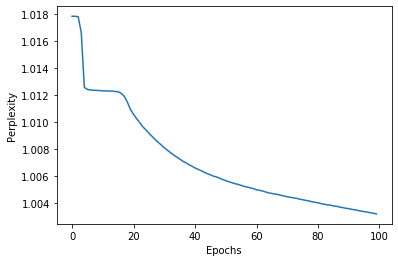

In [0]:
import matplotlib.pyplot as plt

plt.plot(input_set, perplexity_set)
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.show()